In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkb
import h3
from shapely.geometry import Polygon, MultiPolygon, LineString
from shapely.ops import transform
import shapely.wkb as swkb
from functools import partial
import pyproj
import matplotlib.pyplot as plt
import rtree
import osmnx as ox
from shapely.ops import unary_union
from shapely.geometry import Point
from geopy.geocoders import Nominatim
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 



In [2]:
amsterdam = pd.read_parquet("amsterdam_bike_paths_extended.parquet")
cracow = pd.read_parquet("krakow_bike_paths_extended.parquet")

In [3]:
def extract_features(series):
    dict_of_lists = {}
    for d in series:
        for key, value in d.items():
            dict_of_lists.setdefault(key, []).append(value)
            
    return pd.DataFrame(data=dict_of_lists)

def create_gdf(df):
    df['geometry'] = df['geometry'].apply(lambda x: swkb.loads(x, hex = True))
    gdf = gpd.GeoDataFrame(data=df, geometry='geometry')
    gdf = gdf.set_crs('EPSG:4326')
    return gdf
gdf_ams = create_gdf(amsterdam)
gdf_krk = create_gdf(cracow)
gdf_ams

id                                               tags  \
0        4264947  {'abandoned:railway': None, 'access': None, 'a...   
1        4270806  {'abandoned:railway': None, 'access': None, 'a...   
2        4305753  {'abandoned:railway': None, 'access': None, 'a...   
3        4363637  {'abandoned:railway': None, 'access': None, 'a...   
4        4364612  {'abandoned:railway': None, 'access': 'yes', '...   
...          ...                                                ...   
8613  1279692697  {'abandoned:railway': None, 'access': None, 'a...   
8614  1279692698  {'abandoned:railway': None, 'access': None, 'a...   
8615  1279692703  {'abandoned:railway': None, 'access': None, 'a...   
8616  1279692704  {'abandoned:railway': None, 'access': None, 'a...   
8617  1280382142  {'abandoned:railway': None, 'access': None, 'a...   

                                               geometry  
0     LINESTRING (4.92236 52.36544, 4.92237 52.36543...  
1     LINESTRING (4.93089 52.36596, 4.93090 52.36585...  
2       LINESTRING (4.86787 52.32198, 4.86787 52.32192)  
3     LINESTRING (4.91538 52.37115, 4.91544 52.37118...  
4     LINESTRING (4.92291 52.37384, 4.92291 52.37389...  
...                                                 ...  
8613  LINESTRING (4.96860 52.37958, 4.96858 52.37956...  
8614  LINESTRING (4.96840 52.37969, 4.96838 52.37968...  
8615  LINESTRING (4.96858 52.37983, 4.96845 52.37992...  
8616    LINESTRING (4.96882 52.37971, 4.96858 52.37983)  
8617  LINESTRING (4.88000 52.34709, 4.88031 52.34687...  

[8618 rows x 3 columns]

Text(492.9494949494949, 0.5, 'Szerokość geograficzna')

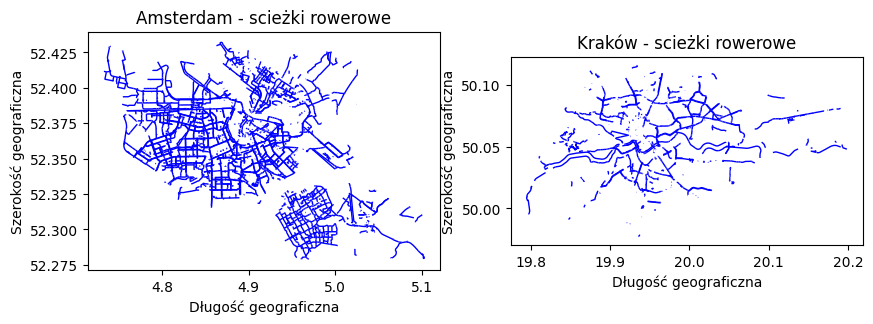

In [4]:
fig, axes = plt.subplots(1,2, figsize = [10, 10])
gdf_ams.plot(ax = axes[0], linewidth = 1, edgecolor = 'blue')

axes[0].set_title('Amsterdam - scieżki rowerowe')
axes[0].set_xlabel('Długość geograficzna')
axes[0].set_ylabel('Szerokość geograficzna')

gdf_krk.plot(ax = axes[1], linewidth = 1, edgecolor = 'blue')

axes[1].set_title('Kraków - scieżki rowerowe')
axes[1].set_xlabel('Długość geograficzna')
axes[1].set_ylabel('Szerokość geograficzna')

In [5]:
# Generowanie heksagonów H3 na obszarze Amsterdamu
def create_h3_hex_grid(df,bounds,epsg=4326):
    resolution = 8  # Rezolucja H3, im wyższa liczba, tym mniejsze heksagony
    buffer = 0.01
    h3_indices = h3.polyfill(
        {
            "type": "Polygon",
            "coordinates": [
                [
                    [bounds["west"], bounds["north"]],
                    [bounds["east"], bounds["north"]],
                    [bounds["east"], bounds["south"]],
                    [bounds["west"], bounds["south"]],
                    [bounds["west"], bounds["north"]],
                ]
            ],
        },
        resolution,
    )
    
    # Konwersja H3 do GeoDataFrame
    hexagons = []
    for h in h3_indices:
        hex_boundary = h3.h3_to_geo_boundary(h, geo_json=True)
        hex_boundary = [(lng, lat) for lat, lng in hex_boundary]
        hex_boundary.append(hex_boundary[0])  # Zamknięcie obwodu heksagonu
        hexagons.append({
            'geometry': Polygon(hex_boundary),
            'h3_index': h
        })
    
    gdf_hex = gpd.GeoDataFrame(hexagons)
    gdf_hex = gdf_hex.set_crs(epsg=epsg)
    
    return gdf_hex
 
# Funkcja przypisująca ścieżki rowerowe do heksagonów
def assign_hexagon(geometry, resolution):
    centroid = geometry.centroid
    return h3.geo_to_h3(centroid.y, centroid.x, resolution)



## Siatka hex z mapą

In [6]:
#Współrzędne granic Amsterdamu i Krakowa
amsterdam_bounds = {"north": 52.441157,"south": 52.2688,"east": 5.1127658,"west": 4.728073}
cracow_bounds = {"north":50.1257,"south":49.9639,"east": 20.215,"west":19.7946}

gdf_ams['h3_index'] = gdf_ams['geometry'].apply(assign_hexagon, resolution=8)
gdf_krk['h3_index'] = gdf_krk['geometry'].apply(assign_hexagon, resolution=8)


gdf_krk_hex = create_h3_hex_grid(gdf_krk,cracow_bounds)    
gdf_ams_hex = create_h3_hex_grid(gdf_ams,amsterdam_bounds)    

amsterdam_area = ox.geocode_to_gdf('Amsterdam, Netherlands')
cracow_area = ox.geocode_to_gdf('Kraków')




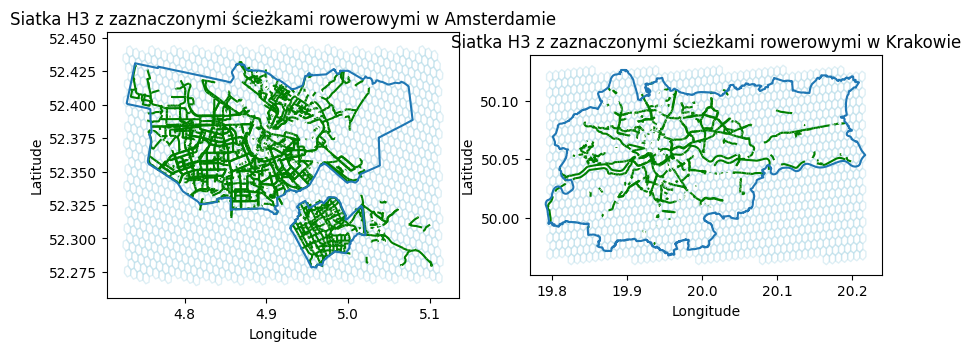

In [7]:
# Wizualizacja
fig, ax = plt.subplots(1,2,figsize=(10, 10))
gdf_ams_hex.plot(ax=ax[0], facecolor='none', edgecolor='lightblue',alpha=0.4)
gdf_ams.plot(ax=ax[0], color='green')
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
ax[0].set_title('Siatka H3 z zaznaczonymi ścieżkami rowerowymi w Amsterdamie')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

gdf_krk_hex.plot(ax=ax[1], facecolor='none', edgecolor='lightblue',alpha=0.4)
gdf_krk.plot(ax=ax[1], color='green')
cracow_area['geometry'].boundary.plot(ax=ax[1])

ax[1].set_title('Siatka H3 z zaznaczonymi ścieżkami rowerowymi w Krakowie')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

plt.show()

## Przycięcie map i heksagonów

In [8]:

def crop_hex_grid(gdf_hex,gdf_bike,gdf_area,epsg):
    gdf_bike = gdf_bike.to_crs(epsg=epsg)
    gdf_hex = gdf_hex.to_crs(epsg=epsg)
    gdf_area = gdf_area.to_crs(epsg=epsg)
    gdf_hex['bike_path_length'] = 0.0
    gdf_hex['within_city'] = False

    for i, polygon in gdf_hex.iterrows():
        clipped = gdf_bike.clip(polygon.geometry)
        within_city = polygon.geometry.intersects(gdf_area.geometry)
        gdf_hex.loc[i,'bike_path_length'] = clipped.length.sum()
        gdf_hex.loc[i,'within_city'] = within_city[0]

    gdf_hex = gdf_hex[(gdf_hex['within_city'] == True) | (gdf_hex['bike_path_length'] > 0)]
    gdf_hex = gdf_hex.to_crs(epsg=4326)
    del gdf_hex['within_city']
    
    return gdf_hex

gdf_ams_hex = crop_hex_grid(gdf_ams_hex, gdf_ams, amsterdam_area, 2180)
gdf_krk_hex = crop_hex_grid(gdf_krk_hex, gdf_krk, cracow_area, 2180)


Text(492.9494949494949, 0.5, 'Latitude')

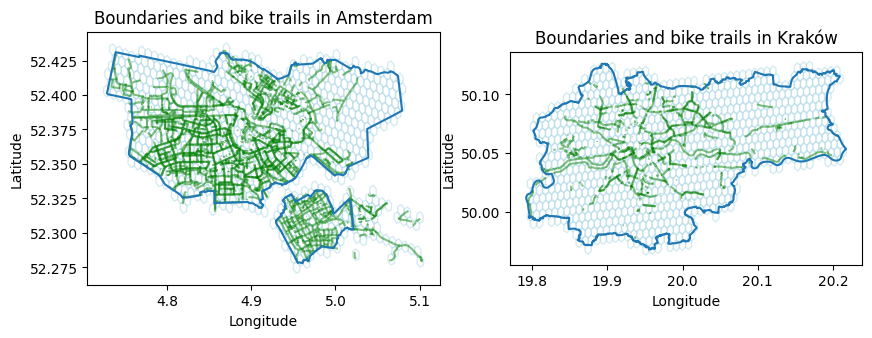

In [9]:
fig, ax = plt.subplots(1,2,figsize = (10,10))
gdf_ams.plot(ax=ax[0], edgecolor='green', facecolor='none', alpha=0.5)
gdf_ams_hex.plot(ax=ax[0], edgecolor='lightblue', facecolor='none', alpha=0.5)
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
# Set plot title and labels
ax[0].set_title('Boundaries and bike trails in Amsterdam')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

gdf_krk.plot(ax=ax[1], edgecolor='green', facecolor='none', alpha=0.5)
gdf_krk_hex.plot(ax=ax[1], edgecolor='lightblue', facecolor='none', alpha=0.5)
cracow_area['geometry'].boundary.plot(ax=ax[1])
# Set plot title and labels
ax[1].set_title('Boundaries and bike trails in Kraków')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

## Hex razem z policzoną długością ścieżki rowerowej

In [10]:
gdf_ams_hex

geometry         h3_index  \
2     POLYGON ((4.79908 52.37604, 4.80307 52.37724, ...  887ab61aa1fffff   
3     POLYGON ((5.06715 52.28920, 5.07113 52.29040, ...  887ab67333fffff   
4     POLYGON ((4.92042 52.39261, 4.92440 52.39381, ...  887ab60b63fffff   
5     POLYGON ((4.92525 52.36614, 4.92924 52.36734, ...  887ab60b15fffff   
8     POLYGON ((4.88630 52.36239, 4.89029 52.36359, ...  887ab60a61fffff   
...                                                 ...              ...   
1384  POLYGON ((4.93895 52.35031, 4.94293 52.35151, ...  887ab60861fffff   
1385  POLYGON ((4.83266 52.33026, 4.83665 52.33146, ...  887ab6189bfffff   
1386  POLYGON ((4.75253 52.37401, 4.75652 52.37521, ...  887ab61135fffff   
1388  POLYGON ((5.02520 52.40024, 5.02917 52.40144, ...  887ab64635fffff   
1389  POLYGON ((5.01370 52.36487, 5.01767 52.36607, ...  887ab646c7fffff   

      bike_path_length  
2          1963.386215  
3           879.127093  
4          2891.441196  
5          4233.607360  
8          2963.103546  
...                ...  
1384       3215.521292  
1385        717.046332  
1386        906.030508  
1388          0.000000  
1389         55.689561  

[752 rows x 3 columns]

In [11]:
gdf_krk_hex

geometry         h3_index  \
1     POLYGON ((19.97167 49.96701, 19.96764 49.96437...  885262c11dfffff   
2     POLYGON ((19.97116 50.06362, 19.96714 50.06099...  885262c09dfffff   
3     POLYGON ((19.83410 50.03853, 19.83007 50.03590...  885262cc35fffff   
4     POLYGON ((20.11638 50.08943, 20.11235 50.08680...  885262d461fffff   
5     POLYGON ((19.98331 50.05772, 19.97928 50.05509...  885262c0d5fffff   
...                                                 ...              ...   
1210  POLYGON ((19.87429 50.06941, 19.87027 50.06678...  885262ceadfffff   
1212  POLYGON ((19.82603 50.03787, 19.82201 50.03524...  885262cdcbfffff   
1214  POLYGON ((20.06802 50.07162, 20.06400 50.06899...  885262d53bfffff   
1216  POLYGON ((20.07627 50.04467, 20.07224 50.04204...  885262d529fffff   
1217  POLYGON ((20.02805 49.99926, 20.02403 49.99662...  885262c049fffff   

      bike_path_length  
1             0.000000  
2           694.103357  
3           155.055509  
4           584.073998  
5          2337.516864  
...                ...  
1210        696.028025  
1212          9.064988  
1214          0.000000  
1216        556.729650  
1217          0.000000  

[841 rows x 3 columns]

## Pozostałe argumenty 


#### -  długość dróg głównych i chodników



In [12]:
def calculate_road_lengths(amsterdam_bounds, gdf_ams_hex,hex_area):
    # Get road and walk networks
    Ams_roads = ox.graph_from_bbox(bbox=(amsterdam_bounds['north'],
                                         amsterdam_bounds['south'],
                                         amsterdam_bounds['east'],
                                         amsterdam_bounds['west']), 
                                   network_type='drive')
    Ams_walks = ox.graph_from_bbox(bbox=(amsterdam_bounds['north'],
                                         amsterdam_bounds['south'],
                                         amsterdam_bounds['east'],
                                         amsterdam_bounds['west']), 
                                   network_type='walk')

    # Convert the road network to a GeoDataFrame of edges
    ams_roads = ox.graph_to_gdfs(Ams_roads, nodes=False)
    ams_walks = ox.graph_to_gdfs(Ams_walks, nodes=False)

    # Filter main roads
    ams_roads['highway'] = ams_roads['highway'].apply(lambda x: x[0] if isinstance(x, list) else x)
    main_road_types = ['secondary', 'primary', 'tertiary', 'busway', 'motorway_link', 'motorway']
    ams_roads_main = ams_roads[ams_roads['highway'].isin(main_road_types)]

    # Clip to the hexagonal area
    # hex_area = unary_union(gdf_ams_hex.geometry)
    ams_roads_main_clipped = ams_roads_main.geometry.clip(hex_area)
    ams_walks_clipped = ams_walks.geometry.clip(hex_area)

    # Project to the appropriate CRS
    gdf_ams_hex = gdf_ams_hex.to_crs(epsg=28992)
    ams_roads_main_clipped_proj = ams_roads_main_clipped.to_crs(epsg=28992)
    ams_walks_clipped_proj = ams_walks_clipped.to_crs(epsg=28992)

    # Initialize length columns
    gdf_ams_hex['main_roads_length'] = 0.0
    gdf_ams_hex['walks_length'] = 0.0

    # Calculate lengths for each hexagon
    for i, polygon in gdf_ams_hex.iterrows():
        clipped_r = ams_roads_main_clipped_proj.clip(polygon.geometry)
        clipped_w = ams_walks_clipped_proj.clip(polygon.geometry)
        gdf_ams_hex.at[i, 'main_roads_length'] = clipped_r.length.sum()
        gdf_ams_hex.at[i, 'walks_length'] = clipped_w.length.sum()

    # Reproject back to the original CRS
    gdf_ams_hex = gdf_ams_hex.to_crs(epsg=4326)

    return gdf_ams_hex,ams_walks_clipped,ams_roads_main_clipped
    


In [13]:
hex_area_ams = unary_union(gdf_ams_hex.geometry)
gdf_ams_hex,ams_walks_clipped,ams_roads_main_clipped = calculate_road_lengths(amsterdam_bounds,gdf_ams_hex, hex_area_ams)
gdf_ams_hex

geometry         h3_index  \
2     POLYGON ((4.79908 52.37604, 4.80307 52.37724, ...  887ab61aa1fffff   
3     POLYGON ((5.06715 52.28920, 5.07113 52.29040, ...  887ab67333fffff   
4     POLYGON ((4.92042 52.39261, 4.92440 52.39381, ...  887ab60b63fffff   
5     POLYGON ((4.92525 52.36614, 4.92924 52.36734, ...  887ab60b15fffff   
8     POLYGON ((4.88630 52.36239, 4.89029 52.36359, ...  887ab60a61fffff   
...                                                 ...              ...   
1384  POLYGON ((4.93895 52.35031, 4.94293 52.35151, ...  887ab60861fffff   
1385  POLYGON ((4.83266 52.33026, 4.83665 52.33146, ...  887ab6189bfffff   
1386  POLYGON ((4.75253 52.37401, 4.75652 52.37521, ...  887ab61135fffff   
1388  POLYGON ((5.02520 52.40024, 5.02917 52.40144, ...  887ab64635fffff   
1389  POLYGON ((5.01370 52.36487, 5.01767 52.36607, ...  887ab646c7fffff   

      bike_path_length  main_roads_length  walks_length  
2          1963.386215        2087.769236  17590.805542  
3           879.127093        1632.718777      0.000000  
4          2891.441196        3351.784125  23994.235818  
5          4233.607360        2619.910349  16263.280680  
8          2963.103546        3654.235299  28364.367178  
...                ...                ...           ...  
1384       3215.521292        3783.022708  24111.956616  
1385        717.046332         923.620926   6786.734853  
1386        906.030508        2298.854546   9058.652463  
1388          0.000000        1085.280283   1303.823314  
1389         55.689561           0.000000   2393.174989  

[752 rows x 5 columns]

In [14]:
hex_area_krk = unary_union(gdf_krk_hex.geometry)
gdf_krk_hex,krk_walks_clipped,krk_roads_main_clipped = calculate_road_lengths(cracow_bounds,gdf_krk_hex, hex_area_krk)
gdf_krk_hex

geometry         h3_index  \
1     POLYGON ((19.97167 49.96701, 19.96764 49.96437...  885262c11dfffff   
2     POLYGON ((19.97116 50.06362, 19.96714 50.06099...  885262c09dfffff   
3     POLYGON ((19.83410 50.03853, 19.83007 50.03590...  885262cc35fffff   
4     POLYGON ((20.11638 50.08943, 20.11235 50.08680...  885262d461fffff   
5     POLYGON ((19.98331 50.05772, 19.97928 50.05509...  885262c0d5fffff   
...                                                 ...              ...   
1210  POLYGON ((19.87429 50.06941, 19.87027 50.06678...  885262ceadfffff   
1212  POLYGON ((19.82603 50.03787, 19.82201 50.03524...  885262cdcbfffff   
1214  POLYGON ((20.06802 50.07162, 20.06400 50.06899...  885262d53bfffff   
1216  POLYGON ((20.07627 50.04467, 20.07224 50.04204...  885262d529fffff   
1217  POLYGON ((20.02805 49.99926, 20.02403 49.99662...  885262c049fffff   

      bike_path_length  main_roads_length  walks_length  
1             0.000000           0.000000   8989.330853  
2           694.103357        1169.776857  45032.250478  
3           155.055509        2038.029127  13310.864095  
4           584.073998         756.883360   3120.093691  
5          2337.516864        1636.808763  43813.923971  
...                ...                ...           ...  
1210        696.028025           0.000000  10650.731720  
1212          9.064988         572.519131  14583.694858  
1214          0.000000        1409.108076   6619.481933  
1216        556.729650           0.000000  11036.232651  
1217          0.000000        3503.378297  24706.424136  

[841 rows x 5 columns]

#####  Wizualizacja

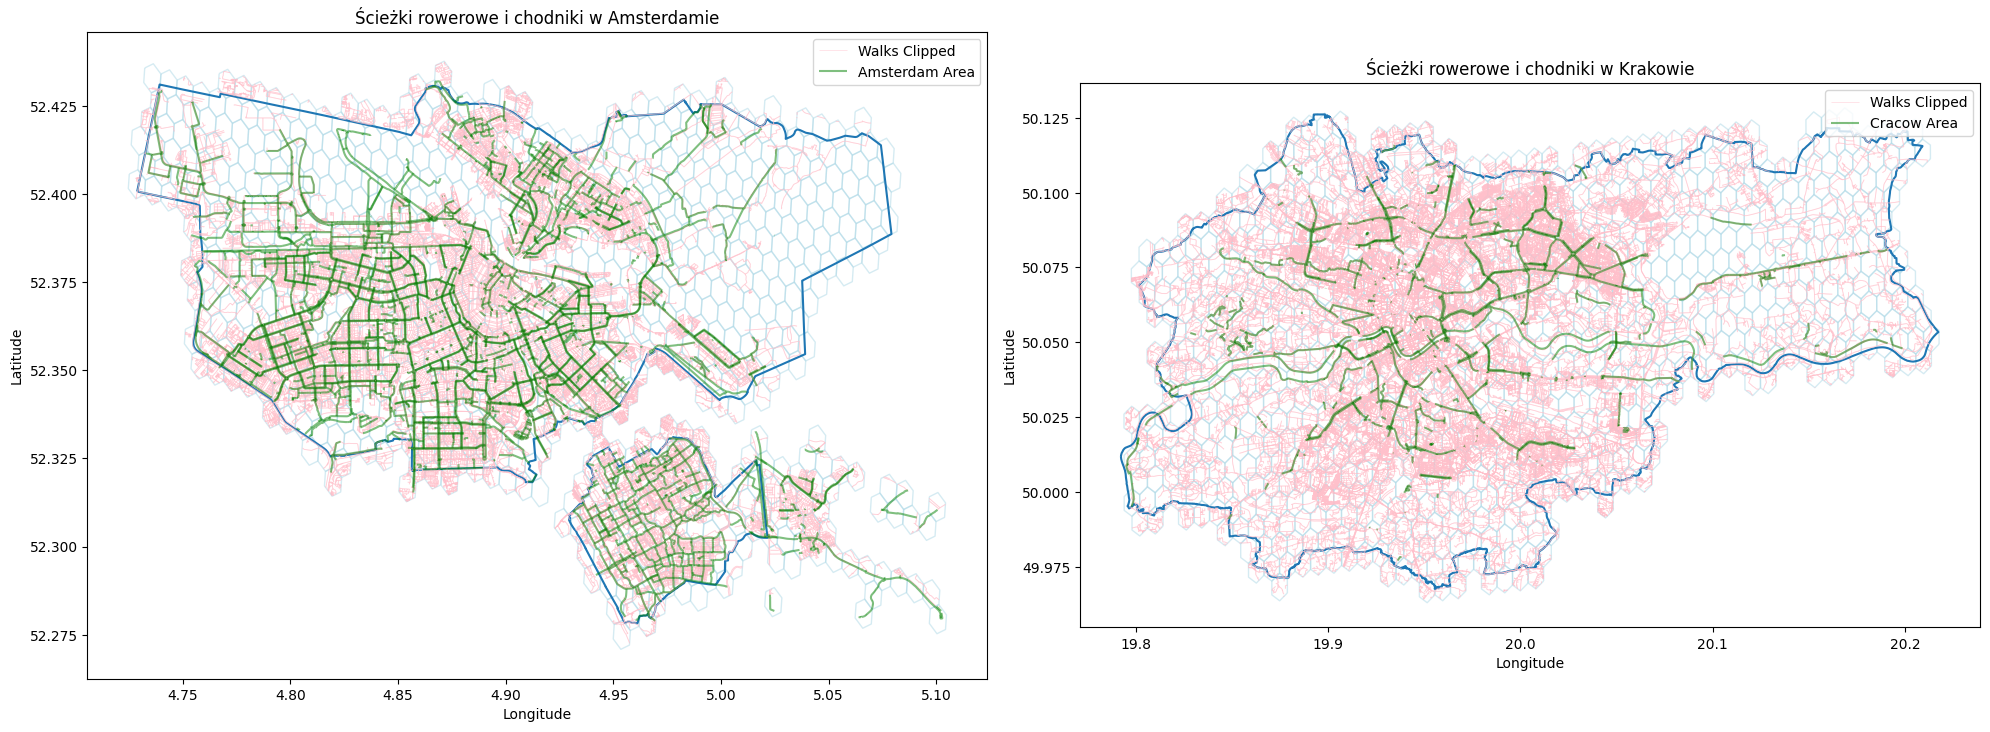

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))  # Adjusted figsize for better visibility
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
ams_walks_clipped.plot(ax=ax[0], edgecolor='pink', facecolor='none', alpha=0.5, linewidth=0.6, label='Walks Clipped')
gdf_ams_hex.plot(ax=ax[0], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
gdf_ams.plot(ax=ax[0], edgecolor='green', facecolor='none', alpha=0.5, label='Amsterdam Area')

ax[0].set_title('Ścieżki rowerowe i chodniki w Amsterdamie')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].legend()

cracow_area['geometry'].boundary.plot(ax=ax[1])
krk_walks_clipped.plot(ax=ax[1], edgecolor='pink', facecolor='none', alpha=0.5, linewidth=0.6, label='Walks Clipped')
gdf_krk_hex.plot(ax=ax[1], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
gdf_krk.plot(ax=ax[1], edgecolor='green', facecolor='none', alpha=0.5, label='Cracow Area')

ax[1].set_title('Ścieżki rowerowe i chodniki w Krakowie')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].legend()

plt.tight_layout()
plt.show()


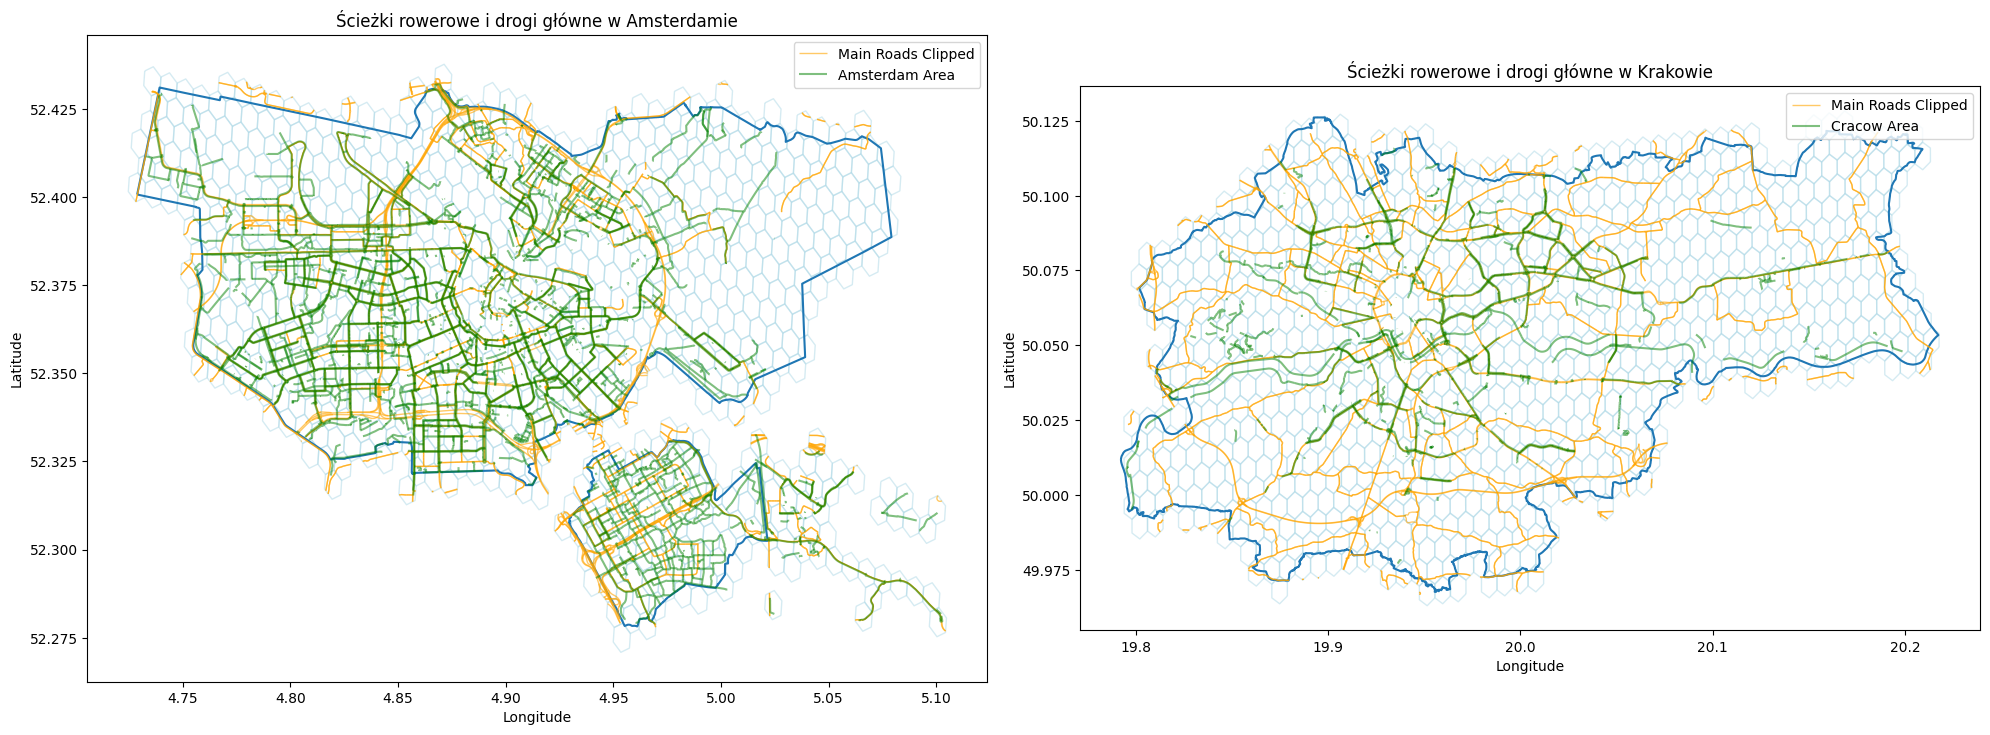

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))  # Adjusted figsize for better visibility
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
ams_roads_main_clipped.plot(ax=ax[0], edgecolor='orange', facecolor='none', alpha=0.6, linewidth=1, label='Main Roads Clipped')
gdf_ams_hex.plot(ax=ax[0], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
gdf_ams.plot(ax=ax[0], edgecolor='green', facecolor='none', alpha=0.5, label='Amsterdam Area')

ax[0].set_title('Ścieżki rowerowe i drogi główne w Amsterdamie')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].legend()

cracow_area['geometry'].boundary.plot(ax=ax[1])
krk_roads_main_clipped.plot(ax=ax[1], edgecolor='orange', facecolor='none', alpha=0.6, linewidth=1, label='Main Roads Clipped')
gdf_krk_hex.plot(ax=ax[1], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
gdf_krk.plot(ax=ax[1], edgecolor='green', facecolor='none', alpha=0.5, label='Cracow Area')

ax[1].set_title('Ścieżki rowerowe i drogi główne w Krakowie')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].legend()

plt.tight_layout()
plt.show()


#### - powierzchnia terenów zielonych

In [17]:
def calculate_green_space_areas(amsterdam_bounds, gdf_ams_hex, hex_area):
    # Get green spaces network
    Ams_green_spaces = ox.geometries_from_bbox(north=amsterdam_bounds['north'],
                                               south=amsterdam_bounds['south'],
                                               east=amsterdam_bounds['east'],
                                               west=amsterdam_bounds['west'],
                                               tags={'leisure': 'park',
                                                     'landuse': ['recreation_ground', 'forest'],
                                                     'natural': 'wood'})

    # Clip to the hexagonal area
    ams_green_spaces_clipped = gpd.clip(Ams_green_spaces, hex_area)

    # Project to the appropriate CRS
    gdf_ams_hex = gdf_ams_hex.to_crs(epsg=28992)
    ams_green_spaces_clipped_proj = ams_green_spaces_clipped.to_crs(epsg=28992)

    # Initialize area columns
    gdf_ams_hex['green_space_area'] = 0.0

    # Calculate areas for each hexagon
    for i, polygon in gdf_ams_hex.iterrows():
        clipped_g = gpd.clip(ams_green_spaces_clipped_proj, polygon.geometry)
        gdf_ams_hex.at[i, 'green_space_area'] = clipped_g.area.sum()

    # Reproject back to the original CRS
    gdf_ams_hex = gdf_ams_hex.to_crs(epsg=4326)

    return gdf_ams_hex, ams_green_spaces_clipped

In [18]:
hex_area_ams = unary_union(gdf_ams_hex.geometry)
gdf_ams_hex,ams_green_spaces_clipped = calculate_green_space_areas(amsterdam_bounds,gdf_ams_hex, hex_area_ams)
gdf_ams_hex

geometry         h3_index  \
2     POLYGON ((4.79908 52.37604, 4.80307 52.37724, ...  887ab61aa1fffff   
3     POLYGON ((5.06715 52.28920, 5.07113 52.29040, ...  887ab67333fffff   
4     POLYGON ((4.92042 52.39261, 4.92440 52.39381, ...  887ab60b63fffff   
5     POLYGON ((4.92525 52.36614, 4.92924 52.36734, ...  887ab60b15fffff   
8     POLYGON ((4.88630 52.36239, 4.89029 52.36359, ...  887ab60a61fffff   
...                                                 ...              ...   
1384  POLYGON ((4.93895 52.35031, 4.94293 52.35151, ...  887ab60861fffff   
1385  POLYGON ((4.83266 52.33026, 4.83665 52.33146, ...  887ab6189bfffff   
1386  POLYGON ((4.75253 52.37401, 4.75652 52.37521, ...  887ab61135fffff   
1388  POLYGON ((5.02520 52.40024, 5.02917 52.40144, ...  887ab64635fffff   
1389  POLYGON ((5.01370 52.36487, 5.01767 52.36607, ...  887ab646c7fffff   

      bike_path_length  main_roads_length  walks_length  green_space_area  
2          1963.386215        2087.769236  17590.805542      33435.606357  
3           879.127093        1632.718777      0.000000       1902.586574  
4          2891.441196        3351.784125  23994.235818     150728.952423  
5          4233.607360        2619.910349  16263.280680       7328.841859  
8          2963.103546        3654.235299  28364.367178      30982.431227  
...                ...                ...           ...               ...  
1384       3215.521292        3783.022708  24111.956616      26030.726051  
1385        717.046332         923.620926   6786.734853     441220.909788  
1386        906.030508        2298.854546   9058.652463     118705.459305  
1388          0.000000        1085.280283   1303.823314      10878.485327  
1389         55.689561           0.000000   2393.174989          0.000000  

[752 rows x 6 columns]

In [19]:
hex_area_krk = unary_union(gdf_krk_hex.geometry)
gdf_krk_hex,krk_green_spaces_clipped = calculate_green_space_areas(cracow_bounds,gdf_krk_hex, hex_area_krk)
gdf_krk_hex

/tmp/ipykernel_1474940/3490342604.py:3: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  Ams_green_spaces = ox.geometries_from_bbox(north=amsterdam_bounds['north'],
/home/jupyter-kosta/.local/lib/python3.10/site-packages/osmnx/geometries.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return features.features_from_bbox(north, south, east, west, tags=tags)


geometry         h3_index  \
1     POLYGON ((19.97167 49.96701, 19.96764 49.96437...  885262c11dfffff   
2     POLYGON ((19.97116 50.06362, 19.96714 50.06099...  885262c09dfffff   
3     POLYGON ((19.83410 50.03853, 19.83007 50.03590...  885262cc35fffff   
4     POLYGON ((20.11638 50.08943, 20.11235 50.08680...  885262d461fffff   
5     POLYGON ((19.98331 50.05772, 19.97928 50.05509...  885262c0d5fffff   
...                                                 ...              ...   
1210  POLYGON ((19.87429 50.06941, 19.87027 50.06678...  885262ceadfffff   
1212  POLYGON ((19.82603 50.03787, 19.82201 50.03524...  885262cdcbfffff   
1214  POLYGON ((20.06802 50.07162, 20.06400 50.06899...  885262d53bfffff   
1216  POLYGON ((20.07627 50.04467, 20.07224 50.04204...  885262d529fffff   
1217  POLYGON ((20.02805 49.99926, 20.02403 49.99662...  885262c049fffff   

      bike_path_length  main_roads_length  walks_length  green_space_area  
1             0.000000           0.000000   8989.330853      27155.153643  
2           694.103357        1169.776857  45032.250478          0.000000  
3           155.055509        2038.029127  13310.864095      14963.029384  
4           584.073998         756.883360   3120.093691       3196.181560  
5          2337.516864        1636.808763  43813.923971      78375.120544  
...                ...                ...           ...               ...  
1210        696.028025           0.000000  10650.731720      15538.872063  
1212          9.064988         572.519131  14583.694858       5314.928126  
1214          0.000000        1409.108076   6619.481933     156046.602680  
1216        556.729650           0.000000  11036.232651       5217.017105  
1217          0.000000        3503.378297  24706.424136       8232.806290  

[841 rows x 6 columns]

/tmp/ipykernel_1474940/2189562412.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[0].legend()
/tmp/ipykernel_1474940/2189562412.py:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[1].legend()


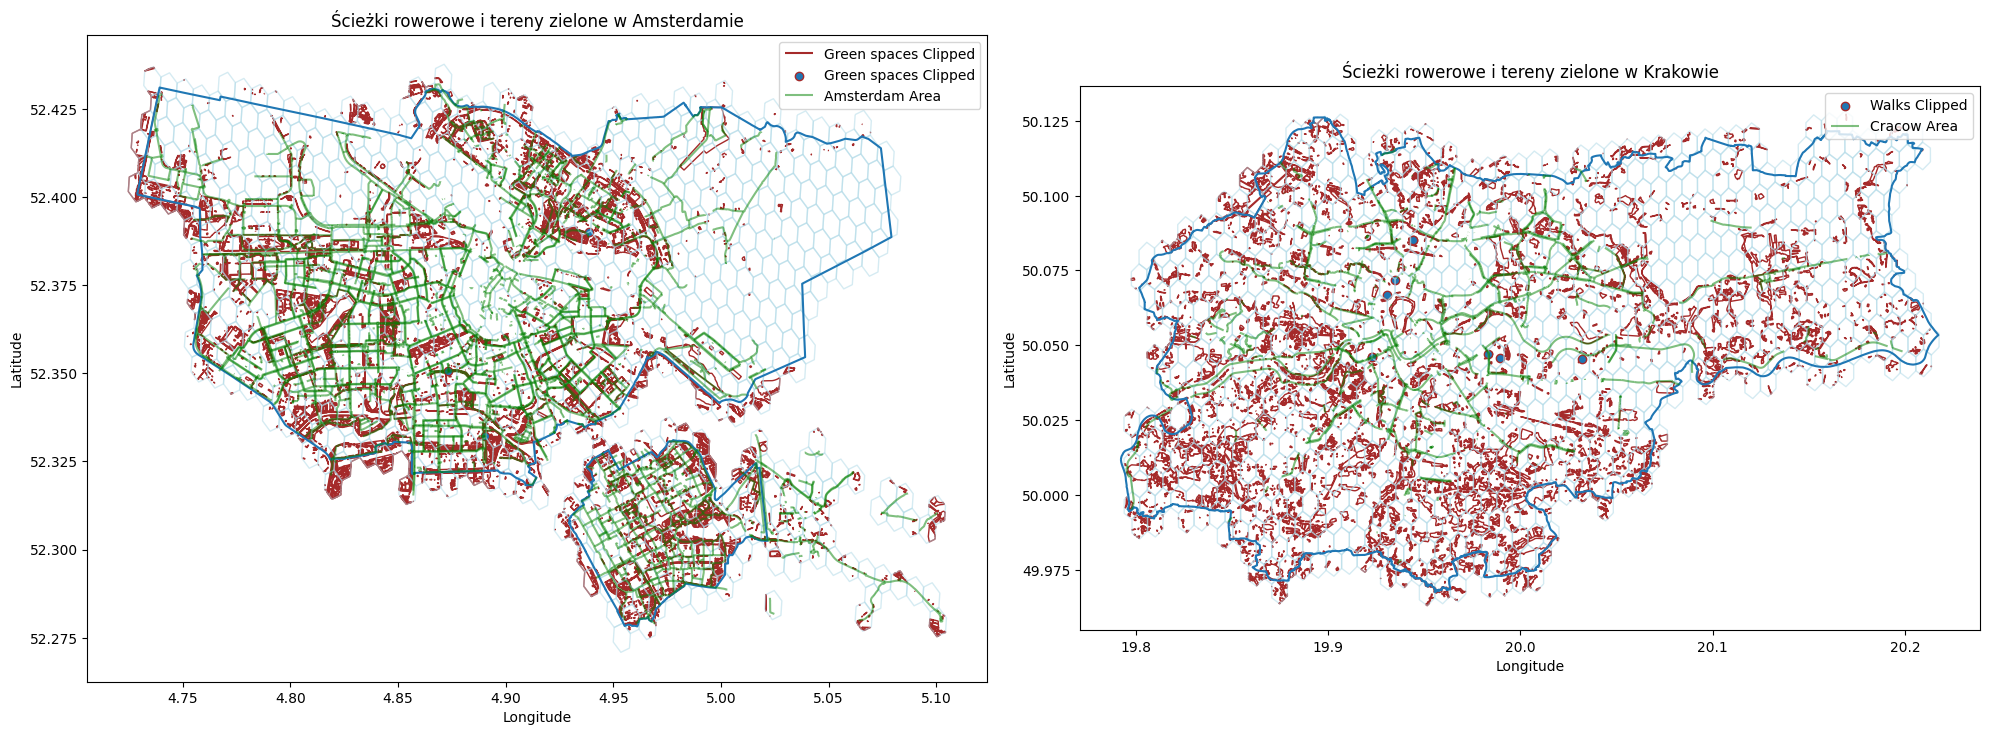

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))  # Adjusted figsize for better visibility
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
ams_green_spaces_clipped.plot(ax=ax[0], edgecolor='brown', facecolor='none', alpha=1, label='Green spaces Clipped')
gdf_ams_hex.plot(ax=ax[0], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
gdf_ams.plot(ax=ax[0], edgecolor='green', facecolor='none', alpha=0.5, label='Amsterdam Area')

ax[0].set_title('Ścieżki rowerowe i tereny zielone w Amsterdamie')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].legend()

cracow_area['geometry'].boundary.plot(ax=ax[1])
krk_green_spaces_clipped.plot(ax=ax[1], edgecolor='brown', facecolor='none', alpha=1, label='Walks Clipped')
gdf_krk_hex.plot(ax=ax[1], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
gdf_krk.plot(ax=ax[1], edgecolor='green', facecolor='none', alpha=0.5, label='Cracow Area')

ax[1].set_title('Ścieżki rowerowe i tereny zielone w Krakowie')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].legend()

plt.tight_layout()
plt.show()


#### - odległość od centrum miasta

In [21]:
def get_city_center(city_name):
    geolocator = Nominatim(user_agent="city_center_locator")
    location = geolocator.geocode(city_name)
    center_gdf = gpd.GeoDataFrame(geometry=[Point(location.longitude, location.latitude)],crs=4326) 
    if location:
        return center_gdf
    else:
        return None
center_amsterdam = get_city_center("Amsterdam, Netherlands")
center_cracow = get_city_center("Kraków, Poland")
center_amsterdam, center_cracow

(                   geometry
 0  POINT (4.89245 52.37308),
                     geometry
 0  POINT (19.99715 50.04694))

In [22]:
def distance_to_city_center(hex_gdf, center_gdf, epsg=28992):
    old_epsg = hex_gdf.crs.to_epsg()
    center_gdf_proj = center_gdf.to_crs(epsg=epsg)
    hex_gdf = hex_gdf.to_crs(epsg=epsg)
    hex_gdf['distance_to_city_center'] = hex_gdf.geometry.centroid.distance(center_gdf_proj.iloc[0,0])
    hex_gdf = hex_gdf.to_crs(epsg=old_epsg)
    return hex_gdf
    
gdf_ams_hex = distance_to_city_center(gdf_ams_hex, center_amsterdam)
gdf_krk_hex = distance_to_city_center(gdf_krk_hex, center_cracow)

gdf_ams_hex

geometry         h3_index  \
2     POLYGON ((4.79908 52.37604, 4.80307 52.37724, ...  887ab61aa1fffff   
3     POLYGON ((5.06715 52.28920, 5.07113 52.29040, ...  887ab67333fffff   
4     POLYGON ((4.92042 52.39261, 4.92440 52.39381, ...  887ab60b63fffff   
5     POLYGON ((4.92525 52.36614, 4.92924 52.36734, ...  887ab60b15fffff   
8     POLYGON ((4.88630 52.36239, 4.89029 52.36359, ...  887ab60a61fffff   
...                                                 ...              ...   
1384  POLYGON ((4.93895 52.35031, 4.94293 52.35151, ...  887ab60861fffff   
1385  POLYGON ((4.83266 52.33026, 4.83665 52.33146, ...  887ab6189bfffff   
1386  POLYGON ((4.75253 52.37401, 4.75652 52.37521, ...  887ab61135fffff   
1388  POLYGON ((5.02520 52.40024, 5.02917 52.40144, ...  887ab64635fffff   
1389  POLYGON ((5.01370 52.36487, 5.01767 52.36607, ...  887ab646c7fffff   

      bike_path_length  main_roads_length  walks_length  green_space_area  \
2          1963.386215        2087.769236  17590.805542      33435.606357   
3           879.127093        1632.718777      0.000000       1902.586574   
4          2891.441196        3351.784125  23994.235818     150728.952423   
5          4233.607360        2619.910349  16263.280680       7328.841859   
8          2963.103546        3654.235299  28364.367178      30982.431227   
...                ...                ...           ...               ...   
1384       3215.521292        3783.022708  24111.956616      26030.726051   
1385        717.046332         923.620926   6786.734853     441220.909788   
1386        906.030508        2298.854546   9058.652463     118705.459305   
1388          0.000000        1085.280283   1303.823314      10878.485327   
1389         55.689561           0.000000   2393.174989          0.000000   

      distance_to_city_center  
2                 6118.081370  
3                15520.675082  
4                 2830.793603  
5                 2707.188036  
8                 1525.647135  
...                       ...  
1384              4448.282876  
1385              6371.842446  
1386              9290.544294  
1388              9662.174846  
1389              8588.167118  

[752 rows x 7 columns]

In [23]:
gdf_krk_hex

geometry         h3_index  \
1     POLYGON ((19.97167 49.96701, 19.96764 49.96437...  885262c11dfffff   
2     POLYGON ((19.97116 50.06362, 19.96714 50.06099...  885262c09dfffff   
3     POLYGON ((19.83410 50.03853, 19.83007 50.03590...  885262cc35fffff   
4     POLYGON ((20.11638 50.08943, 20.11235 50.08680...  885262d461fffff   
5     POLYGON ((19.98331 50.05772, 19.97928 50.05509...  885262c0d5fffff   
...                                                 ...              ...   
1210  POLYGON ((19.87429 50.06941, 19.87027 50.06678...  885262ceadfffff   
1212  POLYGON ((19.82603 50.03787, 19.82201 50.03524...  885262cdcbfffff   
1214  POLYGON ((20.06802 50.07162, 20.06400 50.06899...  885262d53bfffff   
1216  POLYGON ((20.07627 50.04467, 20.07224 50.04204...  885262d529fffff   
1217  POLYGON ((20.02805 49.99926, 20.02403 49.99662...  885262c049fffff   

      bike_path_length  main_roads_length  walks_length  green_space_area  \
1             0.000000           0.000000   8989.330853      27155.153643   
2           694.103357        1169.776857  45032.250478          0.000000   
3           155.055509        2038.029127  13310.864095      14963.029384   
4           584.073998         756.883360   3120.093691       3196.181560   
5          2337.516864        1636.808763  43813.923971      78375.120544   
...                ...                ...           ...               ...   
1210        696.028025           0.000000  10650.731720      15538.872063   
1212          9.064988         572.519131  14583.694858       5314.928126   
1214          0.000000        1409.108076   6619.481933     156046.602680   
1216        556.729650           0.000000  11036.232651       5217.017105   
1217          0.000000        3503.378297  24706.424136       8232.806290   

      distance_to_city_center  
1                 8986.442152  
2                 3007.601516  
3                12070.067342  
4                 9679.185175  
5                 1923.751111  
...                       ...  
1210              9547.776073  
1212             12654.985161  
1214              5665.667053  
1216              5412.507777  
1217              5473.241697  

[841 rows x 7 columns]

/tmp/ipykernel_1474940/3037703094.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[0].legend()
/tmp/ipykernel_1474940/3037703094.py:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[1].legend()


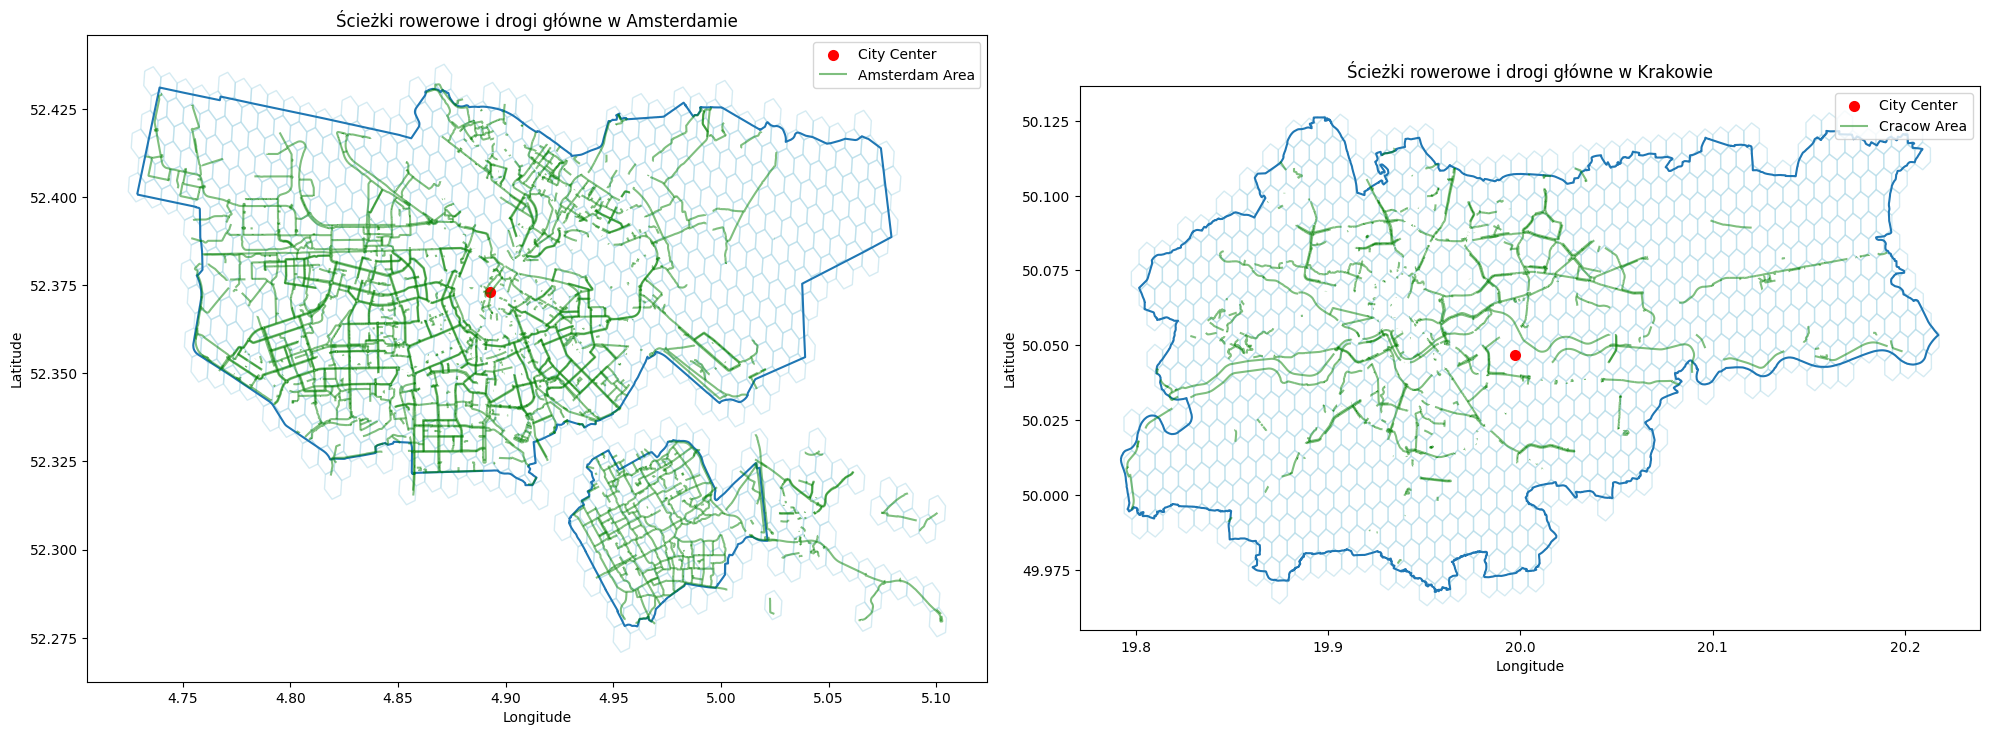

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))  # Adjusted figsize for better visibility
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
gdf_ams_hex.plot(ax=ax[0], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
center_amsterdam.plot(ax=ax[0], color="red", linewidth=2, label='City Center')
gdf_ams.plot(ax=ax[0], edgecolor='green', facecolor='none', alpha=0.5, label='Amsterdam Area')

ax[0].set_title('Ścieżki rowerowe i drogi główne w Amsterdamie')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].legend()

cracow_area['geometry'].boundary.plot(ax=ax[1])
gdf_krk_hex.plot(ax=ax[1], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
center_cracow.plot(ax=ax[1], color='red', linewidth=2, label='City Center')
gdf_krk.plot(ax=ax[1], edgecolor='green', facecolor='none', alpha=0.5, label='Cracow Area')

ax[1].set_title('Ścieżki rowerowe i drogi główne w Krakowie')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].legend()

plt.tight_layout()
plt.show()


#### - ilość lokali usługowych

In [25]:
def calculate_service_amenities(amsterdam_bounds, gdf_ams_hex, hex_area):
    # Get service amenities
    service_amenity_tags = {
        'amenity': True,  # Includes a variety of amenities like restaurants, cafes, schools, etc.
        'shop': True,     # Includes various types of shops
        'office': True    # Includes office buildings
    }
    
    Ams_service_amenities = ox.geometries_from_bbox(north=amsterdam_bounds['north'],
                                                    south=amsterdam_bounds['south'],
                                                    east=amsterdam_bounds['east'],
                                                    west=amsterdam_bounds['west'],
                                                    tags=service_amenity_tags)

    # Clip to the hexagonal area
    ams_service_amenities_clipped = gpd.clip(Ams_service_amenities, hex_area)

    # Initialize a column for counting amenities
    gdf_ams_hex['service_amenity_count'] = 0

    # Calculate the number of amenities for each hexagon
    for i, polygon in gdf_ams_hex.iterrows():
        clipped_amenities = gpd.clip(ams_service_amenities_clipped, polygon.geometry)
        gdf_ams_hex.at[i, 'service_amenity_count'] = clipped_amenities.shape[0]

    return gdf_ams_hex, ams_service_amenities_clipped

In [26]:
hex_area_ams = unary_union(gdf_ams_hex.geometry)
gdf_ams_hex,ams_service_amenities_clipped = calculate_service_amenities(amsterdam_bounds,gdf_ams_hex, hex_area_ams)
gdf_ams_hex

/tmp/ipykernel_1474940/3436094543.py:9: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  Ams_service_amenities = ox.geometries_from_bbox(north=amsterdam_bounds['north'],
/home/jupyter-kosta/.local/lib/python3.10/site-packages/osmnx/geometries.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return features.features_from_bbox(north, south, east, west, tags=tags)


geometry         h3_index  \
2     POLYGON ((4.79908 52.37604, 4.80307 52.37724, ...  887ab61aa1fffff   
3     POLYGON ((5.06715 52.28920, 5.07113 52.29040, ...  887ab67333fffff   
4     POLYGON ((4.92042 52.39261, 4.92440 52.39381, ...  887ab60b63fffff   
5     POLYGON ((4.92525 52.36614, 4.92924 52.36734, ...  887ab60b15fffff   
8     POLYGON ((4.88630 52.36239, 4.89029 52.36359, ...  887ab60a61fffff   
...                                                 ...              ...   
1384  POLYGON ((4.93895 52.35031, 4.94293 52.35151, ...  887ab60861fffff   
1385  POLYGON ((4.83266 52.33026, 4.83665 52.33146, ...  887ab6189bfffff   
1386  POLYGON ((4.75253 52.37401, 4.75652 52.37521, ...  887ab61135fffff   
1388  POLYGON ((5.02520 52.40024, 5.02917 52.40144, ...  887ab64635fffff   
1389  POLYGON ((5.01370 52.36487, 5.01767 52.36607, ...  887ab646c7fffff   

      bike_path_length  main_roads_length  walks_length  green_space_area  \
2          1963.386215        2087.769236  17590.805542      33435.606357   
3           879.127093        1632.718777      0.000000       1902.586574   
4          2891.441196        3351.784125  23994.235818     150728.952423   
5          4233.607360        2619.910349  16263.280680       7328.841859   
8          2963.103546        3654.235299  28364.367178      30982.431227   
...                ...                ...           ...               ...   
1384       3215.521292        3783.022708  24111.956616      26030.726051   
1385        717.046332         923.620926   6786.734853     441220.909788   
1386        906.030508        2298.854546   9058.652463     118705.459305   
1388          0.000000        1085.280283   1303.823314      10878.485327   
1389         55.689561           0.000000   2393.174989          0.000000   

      distance_to_city_center  service_amenity_count  
2                 6118.081370                      4  
3                15520.675082                      4  
4                 2830.793603                    270  
5                 2707.188036                    215  
8                 1525.647135                    278  
...                       ...                    ...  
1384              4448.282876                    304  
1385              6371.842446                      7  
1386              9290.544294                      6  
1388              9662.174846                      1  
1389              8588.167118                      4  

[752 rows x 8 columns]

In [27]:
hex_area_krk = unary_union(gdf_krk_hex.geometry)
gdf_krk_hex,krk_service_amenities_clipped = calculate_service_amenities(cracow_bounds,gdf_krk_hex, hex_area_krk)
gdf_krk_hex

/tmp/ipykernel_1474940/3436094543.py:9: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  Ams_service_amenities = ox.geometries_from_bbox(north=amsterdam_bounds['north'],
/home/jupyter-kosta/.local/lib/python3.10/site-packages/osmnx/geometries.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return features.features_from_bbox(north, south, east, west, tags=tags)


geometry         h3_index  \
1     POLYGON ((19.97167 49.96701, 19.96764 49.96437...  885262c11dfffff   
2     POLYGON ((19.97116 50.06362, 19.96714 50.06099...  885262c09dfffff   
3     POLYGON ((19.83410 50.03853, 19.83007 50.03590...  885262cc35fffff   
4     POLYGON ((20.11638 50.08943, 20.11235 50.08680...  885262d461fffff   
5     POLYGON ((19.98331 50.05772, 19.97928 50.05509...  885262c0d5fffff   
...                                                 ...              ...   
1210  POLYGON ((19.87429 50.06941, 19.87027 50.06678...  885262ceadfffff   
1212  POLYGON ((19.82603 50.03787, 19.82201 50.03524...  885262cdcbfffff   
1214  POLYGON ((20.06802 50.07162, 20.06400 50.06899...  885262d53bfffff   
1216  POLYGON ((20.07627 50.04467, 20.07224 50.04204...  885262d529fffff   
1217  POLYGON ((20.02805 49.99926, 20.02403 49.99662...  885262c049fffff   

      bike_path_length  main_roads_length  walks_length  green_space_area  \
1             0.000000           0.000000   8989.330853      27155.153643   
2           694.103357        1169.776857  45032.250478          0.000000   
3           155.055509        2038.029127  13310.864095      14963.029384   
4           584.073998         756.883360   3120.093691       3196.181560   
5          2337.516864        1636.808763  43813.923971      78375.120544   
...                ...                ...           ...               ...   
1210        696.028025           0.000000  10650.731720      15538.872063   
1212          9.064988         572.519131  14583.694858       5314.928126   
1214          0.000000        1409.108076   6619.481933     156046.602680   
1216        556.729650           0.000000  11036.232651       5217.017105   
1217          0.000000        3503.378297  24706.424136       8232.806290   

      distance_to_city_center  service_amenity_count  
1                 8986.442152                      2  
2                 3007.601516                    230  
3                12070.067342                      5  
4                 9679.185175                      0  
5                 1923.751111                    143  
...                       ...                    ...  
1210              9547.776073                      1  
1212             12654.985161                      9  
1214              5665.667053                      1  
1216              5412.507777                      0  
1217              5473.241697                     17  

[841 rows x 8 columns]

/tmp/ipykernel_1474940/2712504861.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[0].legend()
/tmp/ipykernel_1474940/2712504861.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[1].legend()


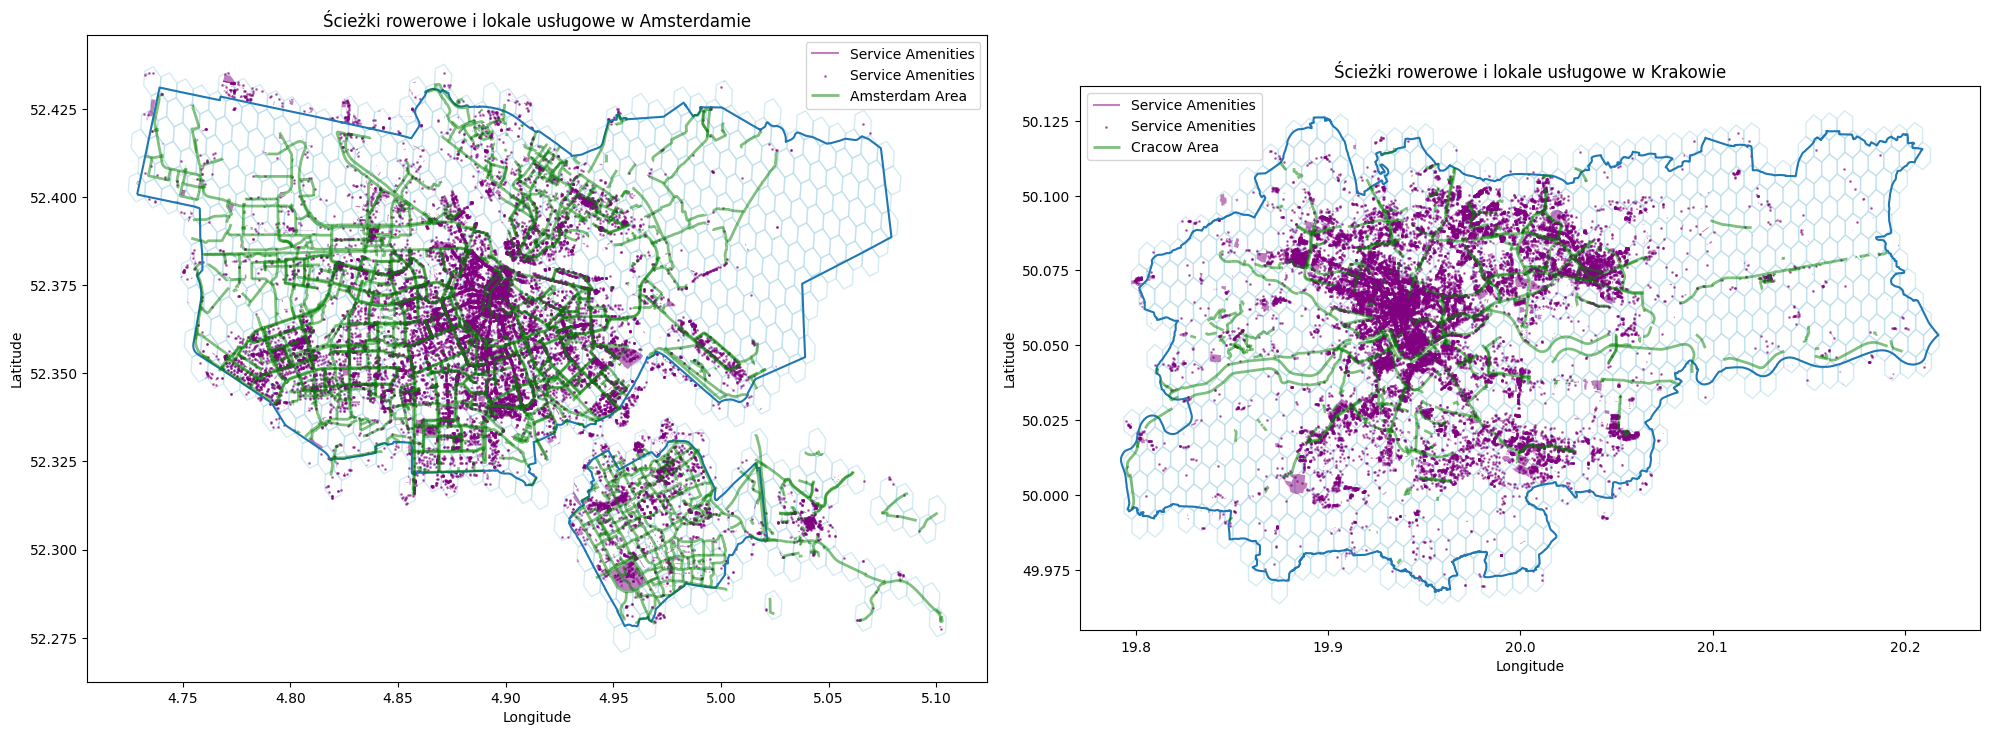

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))  # Adjusted figsize for better visibility

# Plot Amsterdam
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
gdf_ams_hex.plot(ax=ax[0], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
ams_service_amenities_clipped.plot(ax=ax[0], color='purple', markersize=1, alpha=0.5, label='Service Amenities')
gdf_ams.plot(ax=ax[0], edgecolor='green', facecolor='none', alpha=0.5, linewidth=2, label='Amsterdam Area')

ax[0].set_title('Ścieżki rowerowe i lokale usługowe w Amsterdamie')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].legend()

# Plot Kraków
cracow_area['geometry'].boundary.plot(ax=ax[1])
gdf_krk_hex.plot(ax=ax[1], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
krk_service_amenities_clipped.plot(ax=ax[1], color='purple', markersize=1, alpha=0.5, label='Service Amenities')
gdf_krk.plot(ax=ax[1], edgecolor='green', facecolor='none', alpha=0.5, linewidth=2, label='Cracow Area')

ax[1].set_title('Ścieżki rowerowe i lokale usługowe w Krakowie')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].legend()

plt.tight_layout()
plt.show()


## Podsumowanie atrybutów

In [29]:
gdf_ams_hex.to_csv('gdf_ams_hex.csv', index=False)
gdf_krk_hex.to_csv('gdf_krk_hex.csv', index=False)

gdf_ams_hex

geometry         h3_index  \
2     POLYGON ((4.79908 52.37604, 4.80307 52.37724, ...  887ab61aa1fffff   
3     POLYGON ((5.06715 52.28920, 5.07113 52.29040, ...  887ab67333fffff   
4     POLYGON ((4.92042 52.39261, 4.92440 52.39381, ...  887ab60b63fffff   
5     POLYGON ((4.92525 52.36614, 4.92924 52.36734, ...  887ab60b15fffff   
8     POLYGON ((4.88630 52.36239, 4.89029 52.36359, ...  887ab60a61fffff   
...                                                 ...              ...   
1384  POLYGON ((4.93895 52.35031, 4.94293 52.35151, ...  887ab60861fffff   
1385  POLYGON ((4.83266 52.33026, 4.83665 52.33146, ...  887ab6189bfffff   
1386  POLYGON ((4.75253 52.37401, 4.75652 52.37521, ...  887ab61135fffff   
1388  POLYGON ((5.02520 52.40024, 5.02917 52.40144, ...  887ab64635fffff   
1389  POLYGON ((5.01370 52.36487, 5.01767 52.36607, ...  887ab646c7fffff   

      bike_path_length  main_roads_length  walks_length  green_space_area  \
2          1963.386215        2087.769236  17590.805542      33435.606357   
3           879.127093        1632.718777      0.000000       1902.586574   
4          2891.441196        3351.784125  23994.235818     150728.952423   
5          4233.607360        2619.910349  16263.280680       7328.841859   
8          2963.103546        3654.235299  28364.367178      30982.431227   
...                ...                ...           ...               ...   
1384       3215.521292        3783.022708  24111.956616      26030.726051   
1385        717.046332         923.620926   6786.734853     441220.909788   
1386        906.030508        2298.854546   9058.652463     118705.459305   
1388          0.000000        1085.280283   1303.823314      10878.485327   
1389         55.689561           0.000000   2393.174989          0.000000   

      distance_to_city_center  service_amenity_count  
2                 6118.081370                      4  
3                15520.675082                      4  
4                 2830.793603                    270  
5                 2707.188036                    215  
8                 1525.647135                    278  
...                       ...                    ...  
1384              4448.282876                    304  
1385              6371.842446                      7  
1386              9290.544294                      6  
1388              9662.174846                      1  
1389              8588.167118                      4  

[752 rows x 8 columns]

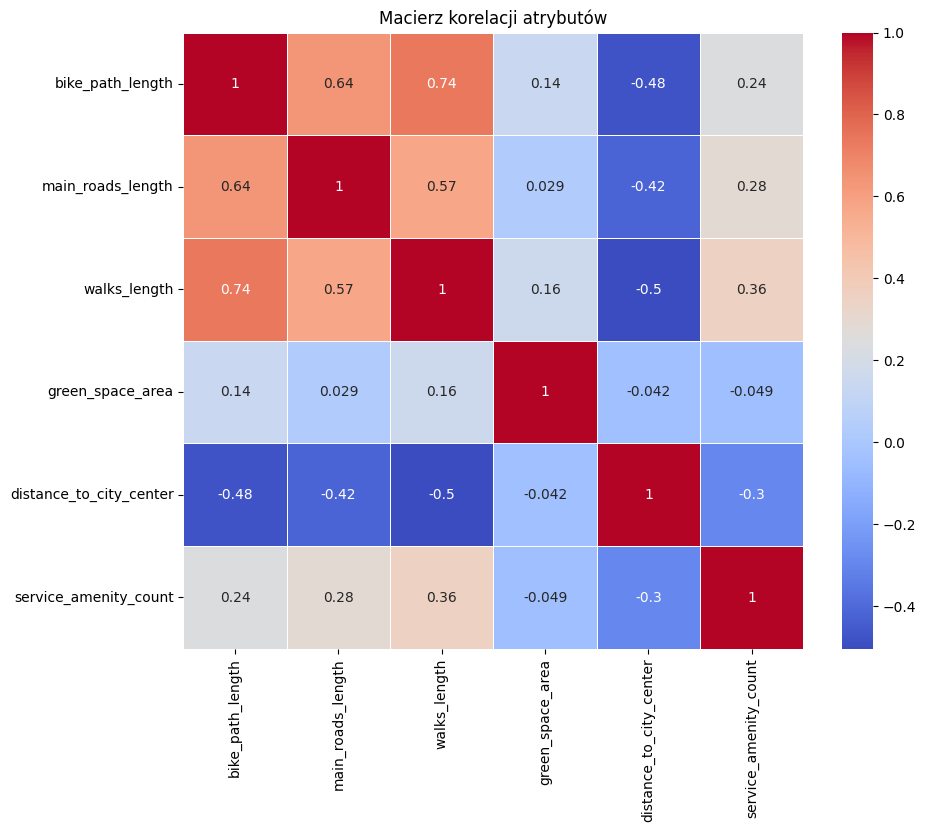

In [30]:
# Obliczanie macierzy korelacji
correlation_matrix = gdf_ams_hex[['bike_path_length','main_roads_length','walks_length','green_space_area','distance_to_city_center','service_amenity_count']].corr()

# Wizualizacja macierzy korelacji za pomocą heatmapy
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Macierz korelacji atrybutów')
plt.show()

## MLFlow

In [31]:
import mlflow
import mlflow.sklearn
import mlflow.tensorflow
import mlflow.pyfunc
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from shapely import wkt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import contextily as ctx

# gdf_ams_hex = pd.read_csv('gdf_ams_hex.csv')
# gdf_krk_hex = pd.read_csv('gdf_krk_hex.csv')
# # Konwersja kolumny 'geometry' na obiekty geograficzne
# gdf_ams_hex['geometry'] = gdf_ams_hex['geometry'].apply(wkt.loads)
# gdf_krk_hex['geometry'] = gdf_krk_hex['geometry'].apply(wkt.loads)
# gdf_ams_hex = gpd.GeoDataFrame(gdf_ams_hex, geometry='geometry')
# gdf_krk_hex = gpd.GeoDataFrame(gdf_krk_hex, geometry='geometry')

2024-06-12 15:48:41.580578: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-12 15:48:41.581124: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-12 15:48:41.584232: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-12 15:48:41.617002: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 15:48:42.551227: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [32]:
# Split data into features and target variable
X = gdf_ams_hex.drop(['bike_path_length', 'geometry', 'h3_index'], axis = 1)
y = gdf_ams_hex['bike_path_length']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.4, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42)

In [33]:
mlflow.set_experiment('Amsterdam_Bike_Paths_Prediction')

<Experiment: artifact_location='file:///home/jupyter-kosta/geo/mlruns/680063318948441799', creation_time=1718194898642, experiment_id='680063318948441799', last_update_time=1718194898642, lifecycle_stage='active', name='Amsterdam_Bike_Paths_Prediction', tags={}>

In [34]:
def train_and_log_model(model, model_name, X_train, y_train, X_val, y_val):
    with mlflow.start_run(run_name=model_name):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        # Metryki
        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        r2 = r2_score(y_val, y_pred)
        
        mlflow.log_metric('MAE', mae)
        mlflow.log_metric('MSE', mse)
        mlflow.log_metric('RMSE', rmse)
        mlflow.log_metric('R2', r2)
        
        mlflow.sklearn.log_model(model, model_name)
        print(f"{model_name} - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}")

In [35]:
# Regresja liniowa
linear_regressor = LinearRegression()
train_and_log_model(linear_regressor, 'Linear Regression', X_train, y_train, X_val, y_val)

# Regresor wektorów nośnych (SVR)
svr_regressor = SVR()
train_and_log_model(svr_regressor, 'Support Vector Regressor', X_train, y_train, X_val, y_val)

# Las losowy
rf_regressor = RandomForestRegressor(random_state=42)
train_and_log_model(rf_regressor, 'Random Forest Regressor', X_train, y_train, X_val, y_val)

# Gradient Boosting Machines (GBM)
gbm_regressor = GradientBoostingRegressor(random_state=42)
train_and_log_model(gbm_regressor, 'Gradient Boosting Regressor', X_train, y_train, X_val, y_val)

/home/jupyter-kosta/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/tljh/user/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
/home/jupyter-kosta/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Linear Regression - MAE: 529.7358061682445, MSE: 483280.76630587486, RMSE: 695.1839801850118, R2: 0.6133623253795069
Support Vector Regressor - MAE: 950.2216392234756, MSE: 1489799.719899808, RMSE: 1220.573520890818, R2: -0.1918800405720218


/home/jupyter-kosta/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Random Forest Regressor - MAE: 495.6441963562405, MSE: 443007.35915586667, RMSE: 665.5879800265827, R2: 0.6455821395644319


/home/jupyter-kosta/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Gradient Boosting Regressor - MAE: 488.1103139692008, MSE: 444398.8696114961, RMSE: 666.6324846656485, R2: 0.6444688935917293


In [36]:
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

with mlflow.start_run(run_name='RandomForest RandomizedSearch'):
    random_search.fit(X_train, y_train)
    
    best_model = random_search.best_estimator_
    mlflow.sklearn.log_model(best_model, 'RandomForest Best Model')
    
    mlflow.log_params(random_search.best_params_)
    
    y_pred = best_model.predict(X_val)
    
    #Metryki
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    r2 = r2_score(y_val, y_pred)
    
    mlflow.log_metric('MAE', mae)
    mlflow.log_metric('MSE', mse)
    mlflow.log_metric('RMSE', rmse)
    mlflow.log_metric('R2', r2)

    print(f"RandomForest Best Model - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
RandomForest Best Model - MAE: 494.8590626752421, MSE: 436738.9890412913, RMSE: 660.8623071724483, R2: 0.6505970050706378


/home/jupyter-kosta/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [37]:
X_krk = gdf_krk_hex.drop(['bike_path_length', 'geometry', 'h3_index'], axis=1)
y_krk_true = gdf_krk_hex['bike_path_length']

y_krk_pred = best_model.predict(X_krk)

In [38]:
mae_krk = mean_absolute_error(y_krk_true, y_krk_pred)
mse_krk = mean_squared_error(y_krk_true, y_krk_pred)
rmse_krk = mean_squared_error(y_krk_true, y_krk_pred, squared=False)
r2_krk = r2_score(y_krk_true, y_krk_pred)

print(f"Kraków - MAE: {mae_krk}, MSE: {mse_krk}, RMSE: {rmse_krk}, R2: {r2_krk}")

with mlflow.start_run(run_name='Krakow Prediction Evaluation'):
    mlflow.log_metric('MAE_Krakow', mae_krk)
    mlflow.log_metric('MSE_Krakow', mse_krk)
    mlflow.log_metric('RMSE_Krakow', rmse_krk)
    mlflow.log_metric('R2_Krakow', r2_krk)

Kraków - MAE: 979.9479796412948, MSE: 1364070.6178306763, RMSE: 1167.934337979099, R2: -2.8435196307156003


/home/jupyter-kosta/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [39]:
X_ams = gdf_ams_hex.drop(['bike_path_length', 'geometry', 'h3_index'], axis=1)
y_ams = gdf_ams_hex['bike_path_length']
y_ams_pred = best_model.predict(X_ams)

# Dodanie przewidywanych wartości do GeoDataFrames
gdf_ams_hex['bike_path_length_pred'] = y_ams_pred
gdf_krk_hex['bike_path_length_pred'] = y_krk_pred

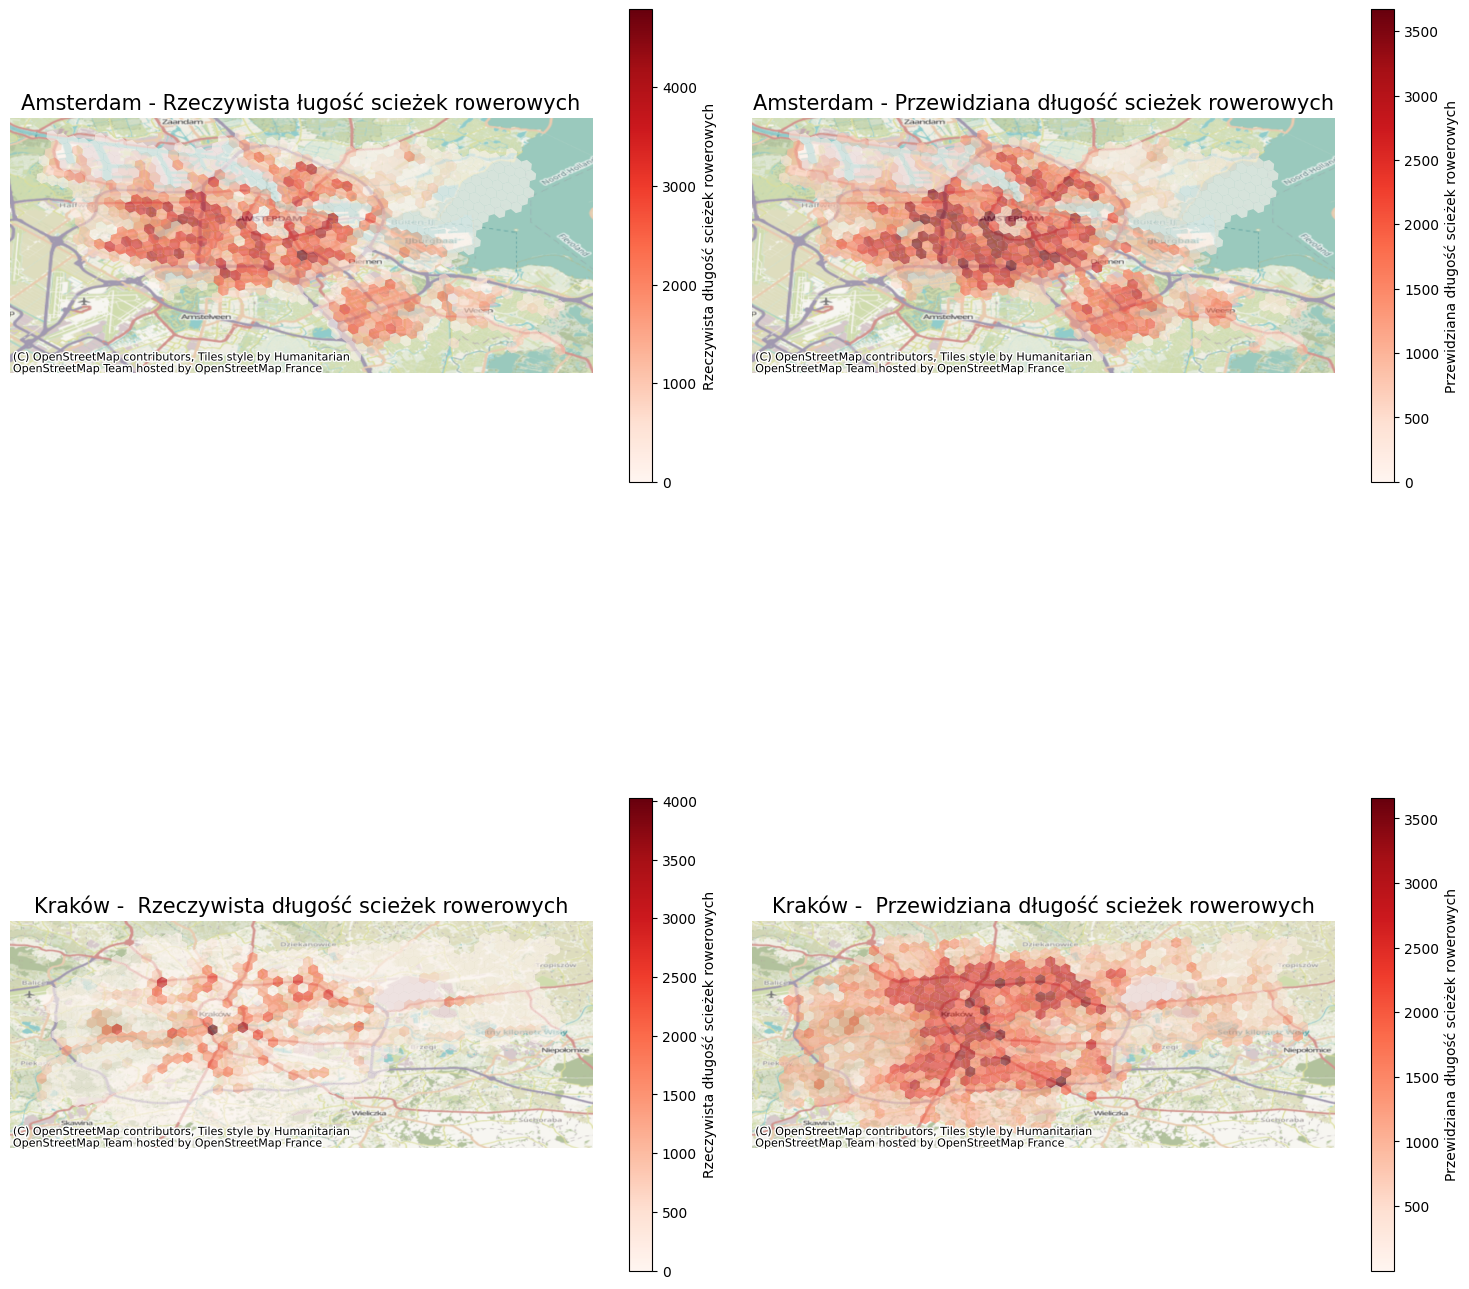

In [40]:
def plot_bike_paths(gdf, true_col, pred_col, title, ax):
    # Plot the true bike path lengths
    gdf.plot(column=true_col, cmap='Reds', legend=True, alpha=0.6, ax=ax, 
             legend_kwds={'label': "Rzeczywista długość scieżek rowerowych", 'orientation': "vertical", 'shrink': 0.4})
    
    # # Plot the predicted bike path lengths
    # gdf.plot(column=pred_col, cmap='Reds', legend=True, alpha=0.6, ax=ax, 
    #          legend_kwds={'label': "Przewidziana długość scieżek rowerowych", 'orientation': "vertical", 'shrink': 0.5})
    
    # Add basemap
    ctx.add_basemap(ax, crs=gdf.crs.to_string())
    
    ax.set_title(title, fontsize=15)
    ax.axis('off')
    
def plot_predicted_bike_paths(gdf, true_col, pred_col, title, ax):

    # Plot the predicted bike path lengths
    gdf.plot(column=pred_col, cmap='Reds', legend=True, alpha=0.6, ax=ax, 
             legend_kwds={'label': "Przewidziana długość scieżek rowerowych", 'orientation': "vertical", 'shrink': 0.4})
    
    # Add basemap
    ctx.add_basemap(ax, crs=gdf.crs.to_string())
    
    ax.set_title(title, fontsize=15)
    ax.axis('off')
    
def plot_pred(gdf_ams_hex, gdf_krk_hex):
    fig, axes = plt.subplots(2, 2, figsize=(15, 20))

    # Mapa dla Amsterdamu
    plot_bike_paths(gdf_ams_hex, 'bike_path_length', 'bike_path_length_pred',
                    'Amsterdam - Rzeczywista ługość scieżek rowerowych', axes[0,0])
    plot_predicted_bike_paths(gdf_ams_hex, 'bike_path_length', 'bike_path_length_pred',
                    'Amsterdam - Przewidziana długość scieżek rowerowych', axes[0,1])

    # Mapa dla Krakowa
    plot_bike_paths(gdf_krk_hex, 'bike_path_length', 'bike_path_length_pred',
                    'Kraków -  Rzeczywista długość scieżek rowerowych', axes[1,0])
    plot_predicted_bike_paths(gdf_krk_hex, 'bike_path_length', 'bike_path_length_pred',
                    'Kraków -  Przewidziana długość scieżek rowerowych', axes[1,1])

    plt.tight_layout()
    # if not os.path.exists("results/"):
    #     os.makedirs("results/")
    # plt.savefig(os.path.join("results/", 'Prawdziwe_i_Przewidziane_ścieżki_rowerowe.png'))
    plt.show()

plot_pred(gdf_ams_hex, gdf_krk_hex)